In [1]:
from tectosaur2.nb_config import setup
setup()

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import integrate_term, refine_surfaces, gauss_rule, tensor_dot
from tectosaur2.mesh import concat_meshes, pts_grid
from tectosaur2.laplace2d import hypersingular

In [3]:
t = sp.var("t")
A = 0.0987
(faultA, faultB) = refine_surfaces(
    [
        (t, 0.5 * (t - 1), A * (t - 1)),
        (t, 0.5 * (t + 1), -A * (t + 1))
    ],
    gauss_rule(8), control_points=np.array([(0, 0, 1, 1.1)])
)
fault = concat_meshes((faultA, faultB))

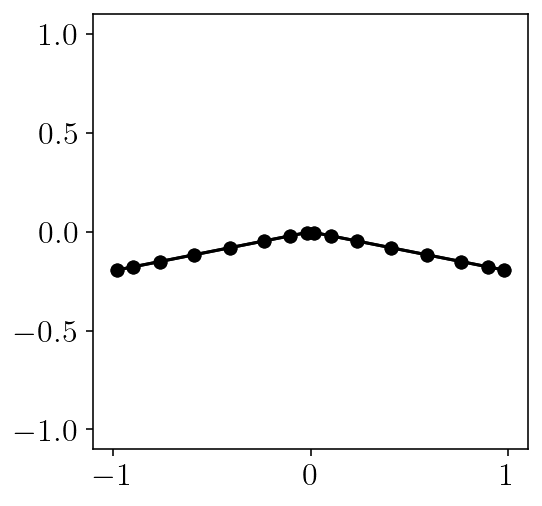

In [4]:
plt.plot(fault.pts[:,0], fault.pts[:,1], 'k-o')
plt.plot(fault.pts[:,0], fault.pts[:,1], 'k-o')
plt.axis('scaled')
plt.ylim([-1.1, 1.1])
plt.xlim([-1.1,1.1])
plt.show()

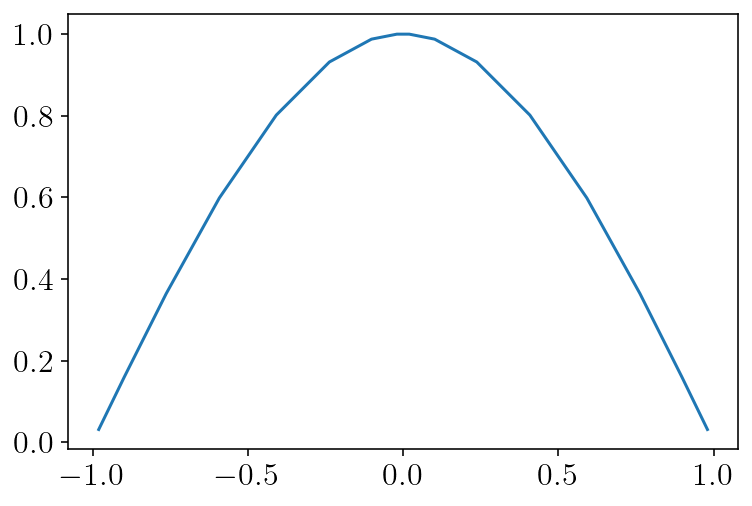

In [5]:

fx = fault.pts[:,0]
slip = np.cos(fx * np.pi * 0.5)
plt.plot(fx, slip)
plt.show()

In [6]:
nobs = 200
zoomx = [-3.2, 3.2]
zoomy = [-3.2, 3.2]
xs = np.linspace(*zoomx, nobs)
ys = np.linspace(*zoomy, nobs)
obs_pts = pts_grid(xs, ys)
obsx = obs_pts[:, 0]
obsy = obs_pts[:, 1]

In [7]:
singularities = np.array([(-1, -A), (0,0), (1, -A)])
get_stress, report = integrate_term(
    hypersingular, obs_pts, fault, singularities=singularities, return_report=True
)



/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:146: UserWarning: Some expanded integrals reached maximum expansion order. These integrals may be inaccurate.
  warnings.warn(


In [8]:
stress = tensor_dot(get_stress, slip)

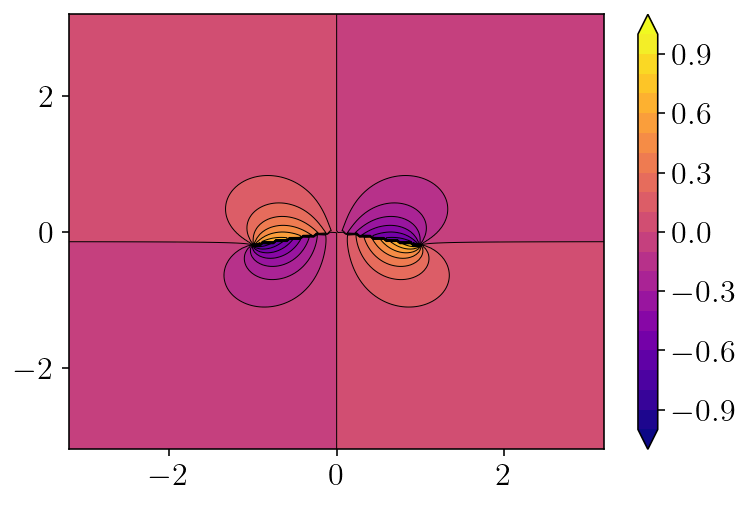

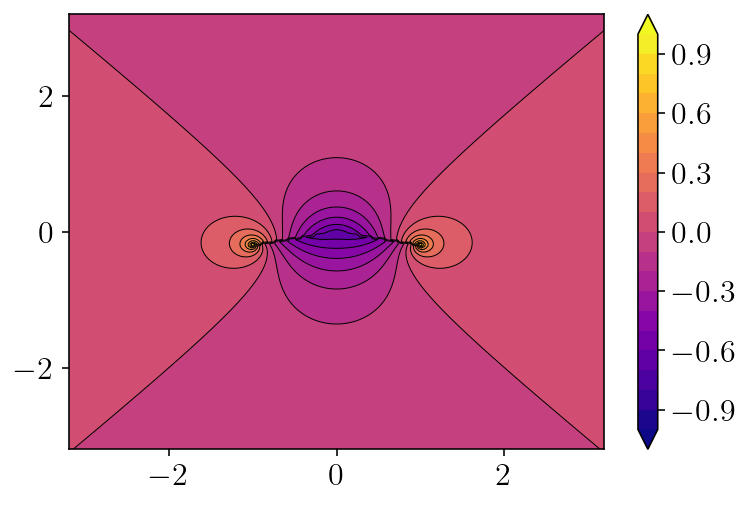

In [9]:
for d in range(2):
    v2d = stress[:,d].reshape((nobs, nobs))
    levels = np.linspace(-1, 1, 21)
    cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
    plt.contour(
        xs,
        ys,
        v2d,
        colors="k",
        linestyles="-",
        linewidths=0.5,
        levels=levels,
        extend="both",
    )
    plt.colorbar(cntf)
    plt.show()

In [10]:
phi = np.arctan(0.6)
h = 0
cohesion = 0.5
stress_trace = 0.5
yield_stress = (-stress_trace / 3) * np.sin(phi) + cohesion * np.cos(phi)

sxz = stress[:,0]
syz = stress[:,1]
devS2 = np.sqrt(sxz ** 2 + syz ** 2)
Lam = 1.0
flow_xz = Lam * sxz / devS2
flow_yz = Lam * syz / devS2
flow_xz, flow_yz

(array([-0.99986004, -0.99998001, -0.99999122, ..., -0.99591111,
        -0.9967972 , -0.99756869]),
 array([ 0.01673001,  0.00632335, -0.0041909 , ..., -0.09033859,
        -0.07997082, -0.06969009]))

In [11]:
yield_stress

0.3429971702850177

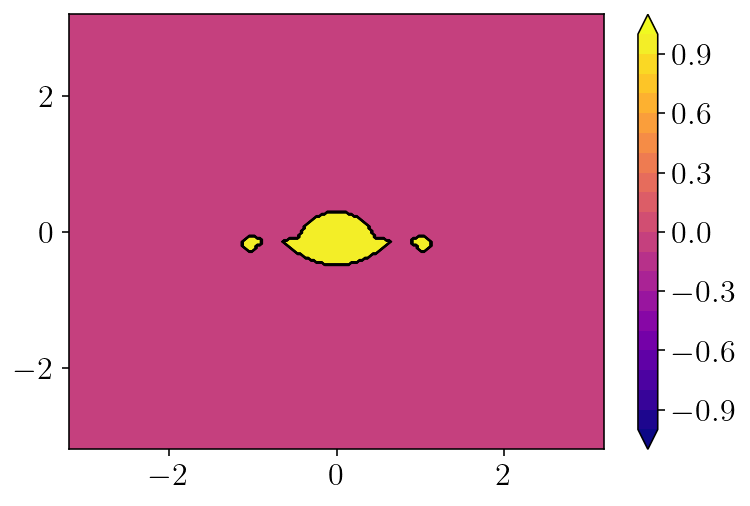

In [12]:
v2d = np.abs(stress[:,1].reshape((nobs, nobs))) > yield_stress
levels = np.linspace(-1, 1, 21)
cntf = plt.contourf(xs, ys, v2d, levels=levels, extend="both")
plt.contour(
    xs,
    ys,
    v2d,
    colors="k",
    linestyles="-",
    linewidths=0.5,
    levels=levels,
    extend="both",
)
plt.colorbar(cntf)
plt.show()

In [80]:
sy = sp.var('s_y')
se_var = sp.var('\\tilde{\\tau}')
sxz, syz = sp.var('s_{xz}, s_{yz}')
exz, eyz = sp.var('e_{xz}, e_{yz}')
h = sp.var('h')
p = sp.var('p')
r = h * p
st = [0,0,sxz,0,0,syz,sxz, syz, 0]
et = [0,0,exz,0,0,eyz,exz, eyz, 0]
trace_st = st[0] + st[4] + st[8]
I = [1,0,0,0,1,0,0,0,1]
dev_st = [st[i] - sp.Rational(1,3) * trace_st * I[i] for i in range(9)]
se = sp.sqrt(sp.Rational(3,2) * sum([dev_st[i] * dev_st[i] for i in range(9)]))
f = se - r - sy
f

-h*p - s_y + sqrt(3*s_{xz}**2 + 3*s_{yz}**2)

In [69]:
dfds = [sp.diff(f, st[i]) if st[i] != 0 else 0 for i in range(9)]

In [70]:
dfds[2].subs(se, se_var)

s_{xz}/\tilde{\tau}

In [16]:
# Why are these different?!!
# dfds[2]
# dev_st[2] * sp.Rational(3,2) / se

In [17]:
dfdp = sp.diff(f, p)
dfdp

-h

In [18]:
lam, mu = sp.var('lam, mu')
C = [[0 for j in range(9)] for i in range(9)]
for i in range(3):
    for j in range(3):
        ij = i * 3 + j
        for k in range(3):
            for l in range(3):
                kl = k * 3 + l
                C[ij][kl] = lam * int(i==j) * int(k==l) + 2*mu * int(i==k) * int(j==l)

In [23]:
dfds_C_dfds = sum([dfds[i] * sum([C[i][j] * dfds[j] for j in range(9)]) for i in range(9)])
#dfds_C_dfds = dfds_C_dfds.simplify()
dfds_C_dfds = dfds_C_dfds.subs(se, se_var)

In [24]:
dfds_C_de = sum([dfds[i] * sum([C[i][j] * et[j] for j in range(9)]) for i in range(9)])
dfds_C_de = dfds_C_de.subs(se, se_var)

In [28]:
dfdp_dfds = dfdp * sp.sqrt(sp.Rational(2, 3) * sum([dfds[i] * dfds[i] for i in range(9)]))
dfdp_dfds = dfdp_dfds.subs(se, se_var)

In [32]:
dlambda = (dfds_C_de / (dfds_C_dfds + dfdp_dfds)).simplify()
dlambda

6*\tilde{\tau}*mu*(e_{xz}*s_{xz} + e_{yz}*s_{yz})/(-sqrt(3)*\tilde{\tau}**2*h*sqrt((s_{xz}**2 + s_{yz}**2)/\tilde{\tau}**2) + 18*mu*s_{xz}**2 + 18*mu*s_{yz}**2)

In [47]:
dep = [(dlambda * dfds[i]).subs(se, se_var) for i in range(9)]

In [49]:
dep[2].simplify()

18*mu*s_{xz}*(e_{xz}*s_{xz} + e_{yz}*s_{yz})/(-sqrt(3)*\tilde{\tau}**2*h*sqrt((s_{xz}**2 + s_{yz}**2)/\tilde{\tau}**2) + 18*mu*s_{xz}**2 + 18*mu*s_{yz}**2)

In [77]:
n = [2 * sp.diff(f, sxz), 2 * sp.diff(f, syz)]
n

[2*s_{xz}/sqrt(s_{xz}**2 + s_{yz}**2), 2*s_{yz}/sqrt(s_{xz}**2 + s_{yz}**2)]

In [86]:
numer = n[0] * mu * exz + n[1] * mu * eyz 
denom = (mu * n[0] ** 2 + mu * n[1] ** 2 + h)
dlam = (numer / denom)
dlam

(2*e_{xz}*mu*s_{xz}/sqrt(s_{xz}**2 + s_{yz}**2) + 2*e_{yz}*mu*s_{yz}/sqrt(s_{xz}**2 + s_{yz}**2))/(h + 4*mu*s_{xz}**2/(s_{xz}**2 + s_{yz}**2) + 4*mu*s_{yz}**2/(s_{xz}**2 + s_{yz}**2))

In [97]:
dep = [(dlam * n[0]).factor(), (dlam * n[1]).factor()]

In [98]:
dep[1]

4*mu*s_{yz}*(e_{xz}*s_{xz} + e_{yz}*s_{yz})/((h + 4*mu)*(s_{xz}**2 + s_{yz}**2))

1. Increment the slip on the fault.
2. Calculate the consequent elastic stress and strain in the volume. 
3. Total strain = elastic strain + past plastic strain
3. Given stress, calculate if F < 0  or F >= 0.
4. If F < 0 --> elastic
5. If F >= 0 --> plastic
6. Calculate $d\lambda_t$
7. Calculate stressing rate
8. Calculate hardening